## BOAR with Transfer Matrix Method
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with transfer matrix modeling (TMM) to optimize the thickness of the layers in a multilayer stack to optimize the average visible transmittance (AVT) and maximize the current density (Jsc) of a solar cell.  
To perform the transfer matrix modeling we use a modified version of the open-source program devoloped by [McGehee's group](https://web.stanford.edu/group/mcgehee/transfermatrix/) (Stanford University) and adapted to python by Kamil Mielczarek (University of Texas).  
For more information about the transfer matrix modeling, please refer to the [original paper](https://doi.org/10.1002/adma.201000883).

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'


# Import libraries
import sys,os
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
mat_dir = os.path.join(os.path.abspath('../'),'Example_Data/matdata') # path to the mat files directory, comment if not in Notebooks folder

In [3]:
# Initialize the agent and default device stack
layers 			= ['SiOx' , 'ITO' , 'ZnO' , 'PCE10_FOIC_1to1' , 'MoOx' , 'Ag', 'MoOx', 'LiF','MoOx', 'LiF','Air'] # list of layers (need to be the same than the name nk_*.csv file in the matdata folder)
thicknesses		= [0 , 100 , 30  , 100 , 9 , 8, 100, 100, 100, 100, 100] # list of thicknesses in nm
        
tm = Transfer_Matrix_agent(layers=layers, thicknesses=thicknesses,mat_dir=mat_dir) # initialize the agent

# Define the free parameters to be optimized

In [4]:
params = []
d_3 = Fitparam(name = 'd_3', val =  80, lims = [40, 100], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL thickness', unit = 'nm')
params.append(d_3)
d_4 = Fitparam(name = 'd_4', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 1 thickness', unit = 'nm')
params.append(d_4)
d_5 = Fitparam(name = 'd_5', val =  10, lims = [0, 15], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Ag thickness', unit = 'nm')
params.append(d_5)
d_6 = Fitparam(name = 'd_6', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 2 thickness', unit = 'nm')
params.append(d_6)
d_7 = Fitparam(name = 'd_7', val =  10, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 1 thickness', unit = 'nm')
params.append(d_7)  
d_8 = Fitparam(name = 'd_8', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 3 thickness', unit = 'nm')
params.append(d_8)
d_9 = Fitparam(name = 'd_9', val =  10, lims = [0, 200], relRange = 0, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 2 thickness', unit = 'nm')
params.append(d_9)

In [5]:
# run the model on the default stack configuration
X = [0] # we need to provide a list of inputs even if it is not used later

print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

Jsc =  10.53248308747983
LUE =  3.5542800166757664
AVT =  0.337458886679895


# Start the optimization

In [6]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = 'Jsc'
target = {'model':partial(tm.TM,output=['Jsc'],is_MOO=True),'target_name':'Jsc','minimize':False,
          'data':{'X':X,'y':[0],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

y_dimension = 'AVT'
target2 = {'model':partial(tm.TM,output=['AVT'],is_MOO=True),'target_name':'AVT','minimize':True,'obj_type':'diff',
          'data':{'X':X,'y':[0.4],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

targets = [target,target2]
obj_type='identity'
loss='linear'
threshold=[8,0.05]

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object
kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':None,'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':True}

ax_client = mo.BoTorchOpti(n_jobs=[1,1], n_step_points = [10, 50], models=['Sobol','MOO'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=True,verbose=True,show_posterior=False,kwargs_posterior=kwargs_posterior,use_custom_func=False)

[INFO 09-20 10:46:41] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-20 10:46:41] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='d_3', parameter_type=FLOAT, range=[4.0, 10.0]), RangeParameter(name='d_4', parameter_type=FLOAT, range=[0.0, 2.0]), RangeParameter(name='d_5', parameter_type=FLOAT, range=[0.0, 1.5]), RangeParameter(name='d_6', parameter_type=FLOAT, range=[0.0, 2.0]), RangeParameter(name='d_7', parameter_type=FLOAT, range=[0.0, 20.0]), RangeParameter(name='d_8', parameter_type=FLOAT, range=[0.0, 2.0])], parameter_constraints=[]).
[INFO 09-20 10:46:41] ax.service.ax_client: Generated new trial 0 with parameters {'d_3': 9.020724, 'd_4': 0.936252, 'd_5': 0.966917, 'd_6': 1.48143, 'd_7': 19.038279, 'd_8': 1.630564}.
[INFO 09-20 10:46:44] ax.service.ax_client: Completed

In [7]:
# Print the optimized stack structure
for p in mo.params:
    print(p.display_name + f' {p.val:.0f} nm')

AL thickness 56 nm
MoOx 1 thickness 8 nm
Ag thickness 7 nm
MoOx 2 thickness 183 nm
LiF 1 thickness 165 nm
MoOx 3 thickness 64 nm
LiF 2 thickness 10 nm


In [8]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
print(triedX.head())
triedY = ax_client.experiment.fetch_data().df
print(triedY.head())

[INFO 09-20 10:52:58] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


   Generation Step Generation Model  Trial Index Trial Status  \
0                0            Sobol            0    COMPLETED   
1                0            Sobol            1    COMPLETED   
2                0            Sobol            2    COMPLETED   
3                0            Sobol            3    COMPLETED   
4                0            Sobol            4    COMPLETED   

                               Arm Parameterizations  
0  {'0_0': {'d_3': 9.02, 'd_4': 0.94, 'd_5': 0.97...  
1  {'1_0': {'d_3': 5.14, 'd_4': 1.58, 'd_5': 1.14...  
2  {'2_0': {'d_3': 8.22, 'd_4': 1.04, 'd_5': 0.76...  
3  {'3_0': {'d_3': 6.5, 'd_4': 1.51, 'd_5': 1.02,...  
4  {'4_0': {'d_3': 8.12, 'd_4': 0.26, 'd_5': 0.42...  
  arm_name   metric_name       mean  sem  trial_index
0      0_0  identity_Jsc  11.703561  NaN            0
1      0_0      diff_AVT   0.003930  NaN            0
2      1_0  identity_Jsc   9.271020  NaN            1
3      1_0      diff_AVT   0.091688  NaN            1
4      2_

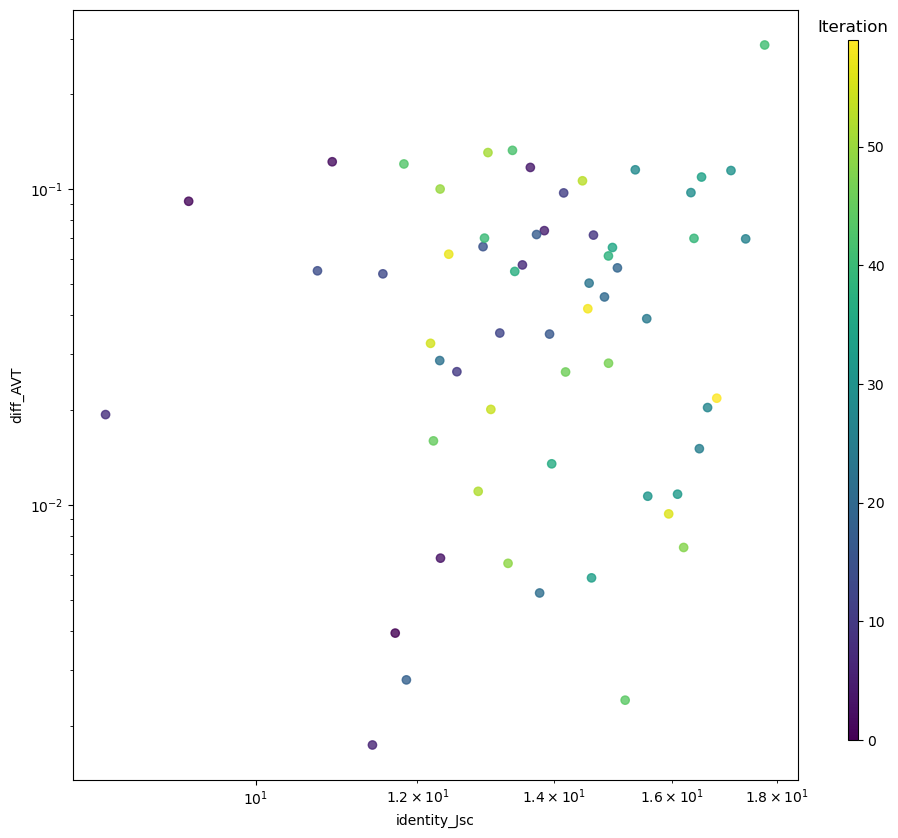

In [9]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

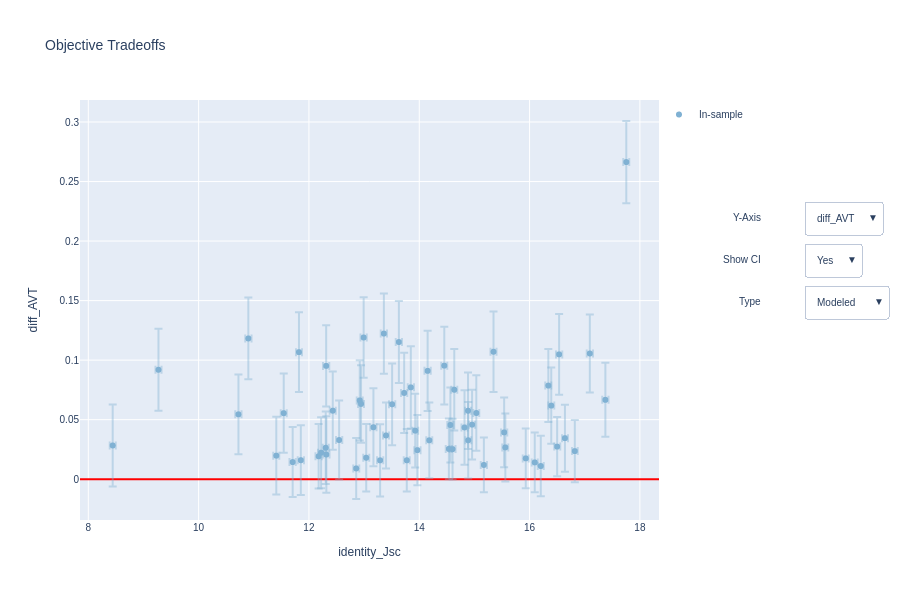

In [10]:
# Interactive plotting of the objective function tradeoffs
model = ax_client.generation_strategy.model
render(plot_objective_vs_constraints(model, 'identity_Jsc', rel=False))

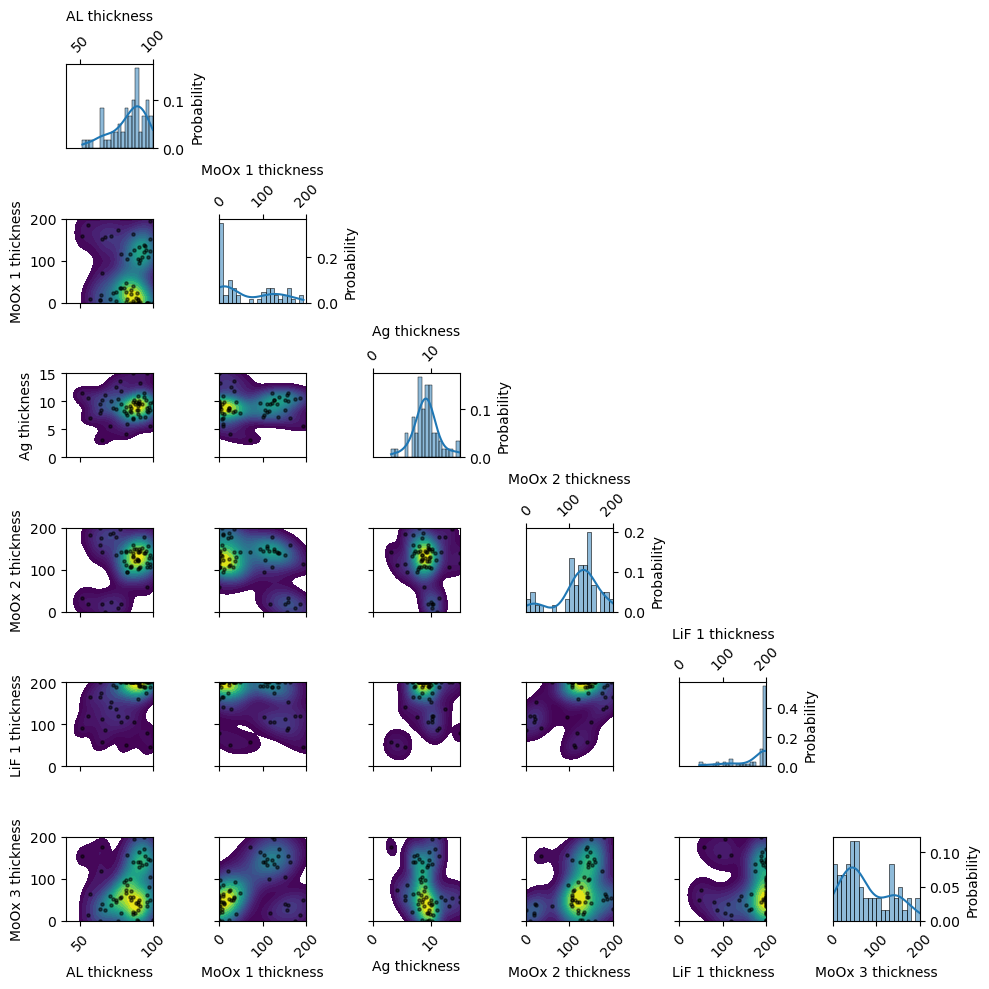

In [11]:
# Plot the density of points that were sampled during the optimization process
mo.plot_density(ax_client,figsize=(10,10))

[INFO 09-20 10:53:02] ax.service.ax_client: Retrieving contour plot with parameter 'd_6' on X-axis and 'd_7' on Y-axis, for metric 'identity_Jsc'. Remaining parameters are affixed to the middle of their range.


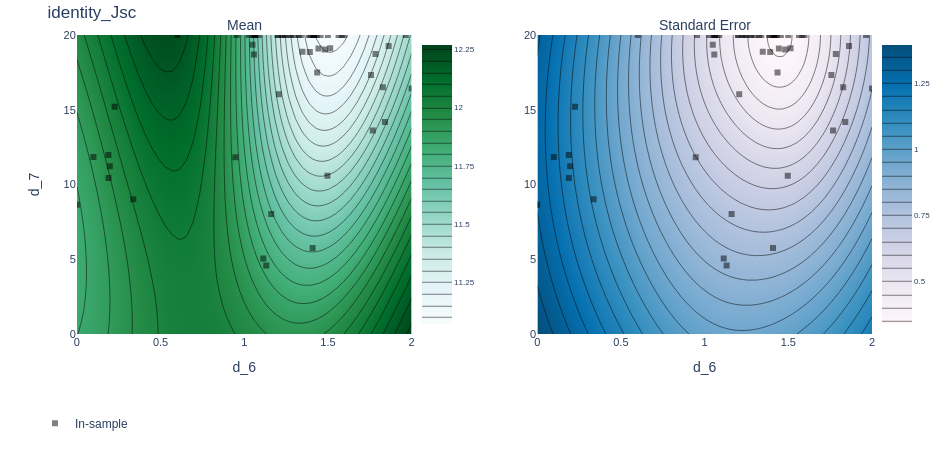

In [12]:
# Plot the contour of the objective function for a given target
render(ax_client.get_contour_plot(param_x="d_6", param_y="d_7", metric_name=obj_type+'_'+target['target_name']))

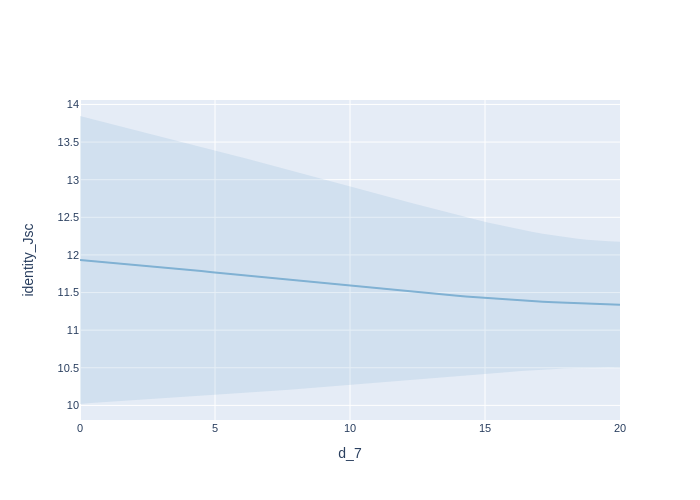

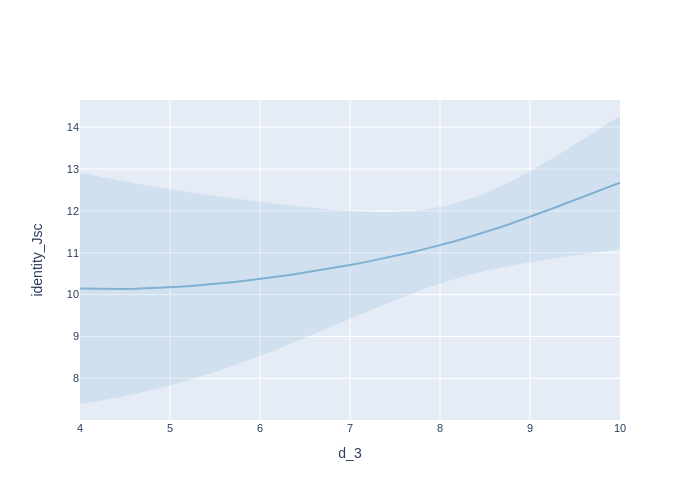

In [13]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
render(plot_slice(model, "d_7", obj_type+'_'+target['target_name']))
render(plot_slice(model, "d_3", obj_type+'_'+target['target_name']))

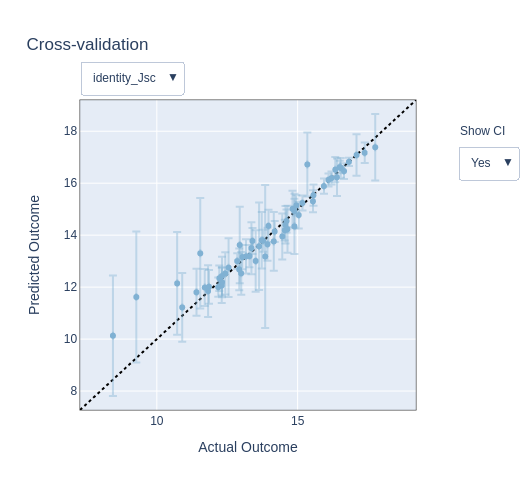

In [14]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

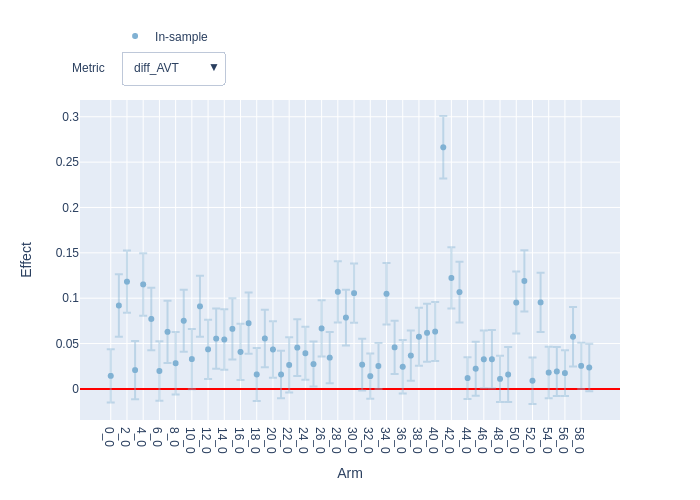

In [15]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))

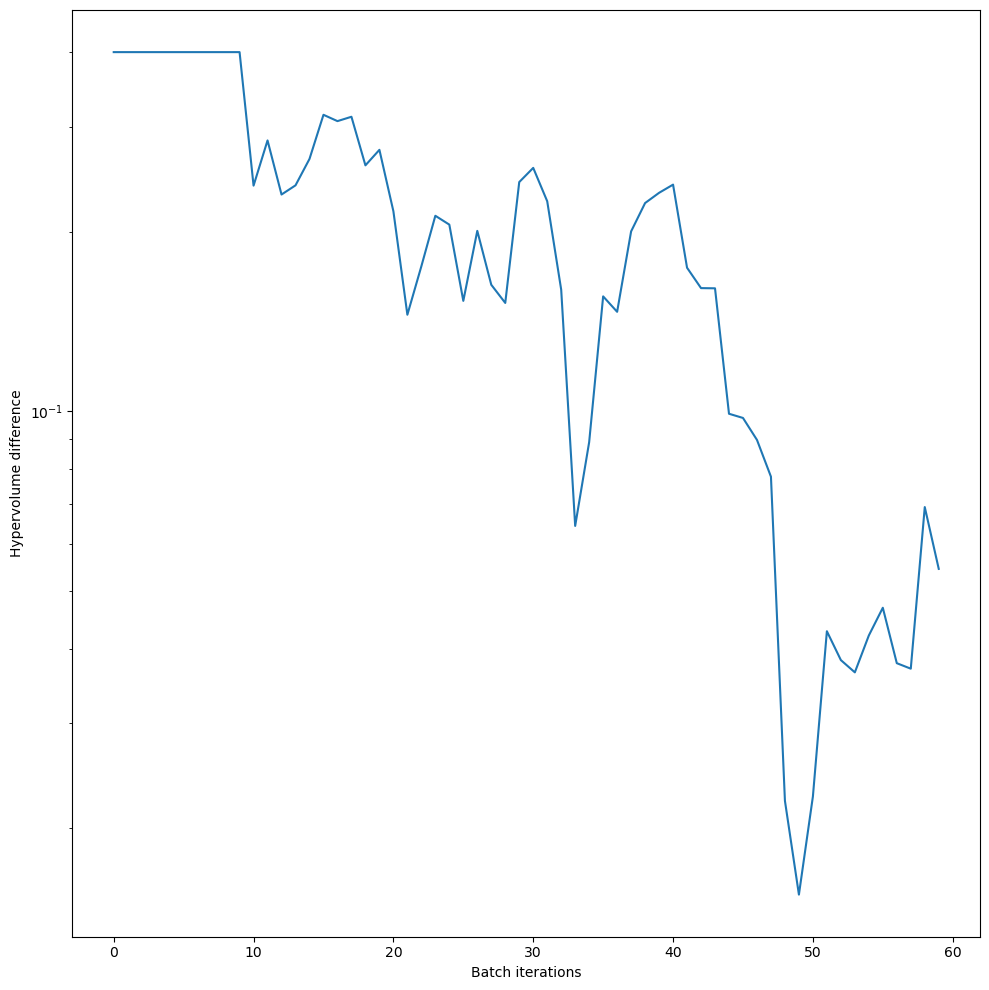

In [16]:
# Plot the hypervolume evolution during the optimization
mo.plot_hypervolume(logscale=True,figsize=(10,10))

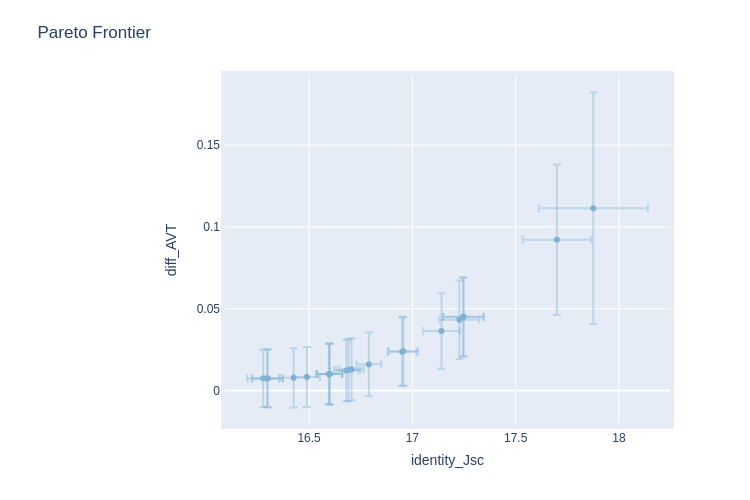

In [17]:
# Compute and plot the Pareto frontier
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["diff_AVT", "identity_Jsc"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 